# Assessment of self-consumption value for typical household profile with PV generation and battery storage: Influence of the timestep and max battery power

This worksheet computes the self-consumption indicators for different PV and household historical demand profiles.  

The selected format is the open-source Ipython Notebook format, which allows to easily follow and check all calculations and hypotheses. 

Sylvain Quoilin

Researcher at the European Commission (JRC).

E-mail: sylvain.quoilin@ec.europa.eu - Twitter: @squoilin

NB: The views expressed are purely those of the author and may not in any circumstances be regarded as stating an official position of the European Commission.

February 2016


## Loading Libraries and input data

All libraries are standard libraries that can be downloaded using pip or a package manager.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
import sys
from SC_functions import save,load
%matplotlib inline

Data sources:

- Demand data is obtained from different monitoring campaigns in France, UK and Portugal
- PV generation data is obtained from Meteonorm typical years (TMY2) for the capitals of the considered countries. 


### Historical Curve for 30 UK households

In [2]:
[TimeSeries_hist, HouseInfo_hist] = load('pickle/TimeSeries_UK')

### Measurements on a French household

2 years: 2007 and 2008

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [3]:
[TimeSeries_fr, HouseInfo_fr] = load('pickle/TimeSeries_FR')
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_fr)
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_fr)

### Measurements on Protugese households

Sustdata, extracted 21 housholds with measurements for one year (2011), 1 min

In [4]:
[TimeSeries_pt, HouseInfo_pt] = load('pickle/TimeSeries_PT')
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_pt)
TimeSeries_hist.index = TimeSeries_pt.index
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_pt/1000)

### Loading PV data

Generated with the typical years of meteonorm, and a PV collector model

- orientation: south
- tilt angle: 35°C

In [6]:
solar_data = pd.read_excel('data/meteonorm.xls')
idx = []
for key in solar_data.columns:
    idx.append(str(key.strip()))

solar_data.columns = idx
solar_data_15min = pd.DataFrame(columns = solar_data.columns,index=np.arange(35040))

for key in solar_data.columns:
    solar_data_15min[key] = pd.Series(data=np.interp(np.linspace(start=0,stop=8760,num=8760*4),range(8760),solar_data[key].values))

### Plotting a sample of the data, historical 15min values

Yearly PV generation: 9646.03158333 kWh
Yearly demand: 9646.03158333 kWh
Self Consumption: 3108.28351925 kWh
SSR = 0.322234433134
SCR = 0.322234433134


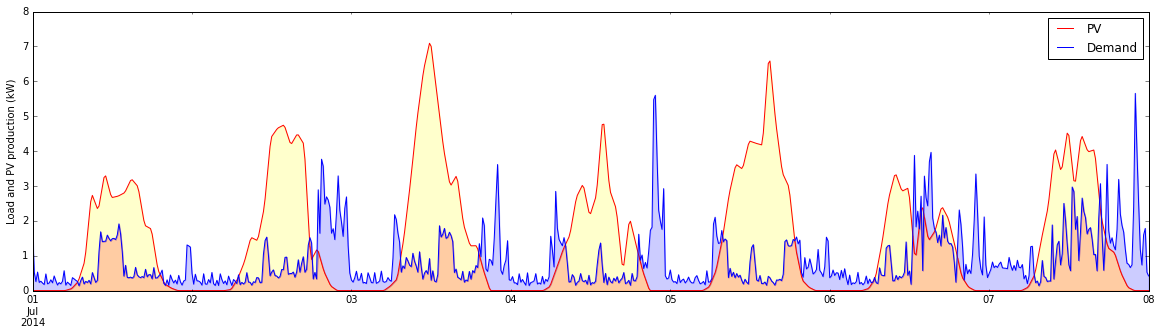

In [29]:
house_id = 33002
start = '07/01/2014 00:00:00'     # start of plotting interval
end = '07/08/2014 00:00:00'       # end of plotting interval
ratio_PV = 1                      # Ratio of yearly PV production to yearly demand

index_2014 = pd.DatetimeIndex(start='01/01/2014 00:00:00',end='31/12/2014 23:45:00',freq='15min')
interval = pd.DatetimeIndex(start=start,end=end,freq='15min')

demand = TimeSeries_hist[house_id]
demand.index = index_2014

PV = solar_data_15min[unicode(HouseInfo_hist['Country'][house_id])]
PV.index = index_2014

PV = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()*4 * ratio_PV
demand = demand * HouseInfo_hist['Annual Consumption'][house_id]/demand.sum()*4

SelfConsumption = np.minimum(PV,demand)

plt.figure(figsize=(20,5))
PV[interval].plot(legend=True,color='red',label='PV')
demand[interval].plot(legend=True,color='blue',label='Demand')
plt.ylabel('Load and PV production (kW)')

plt.fill_between(interval,PV[interval],0,color='yellow',alpha='0.2')
plt.fill_between(interval,SelfConsumption[interval],0,color='red',alpha='0.2')
plt.fill_between(interval,SelfConsumption[interval],demand[interval],color='blue',alpha='0.2')

self_consumption = np.minimum(PV.values,demand.values).sum()/4
SSR = self_consumption/demand.sum()*4
SCR = self_consumption/PV.sum()*4

print 'Yearly PV generation: ' + str(PV.sum()/4) + ' kWh'
print 'Yearly demand: ' + str(demand.sum()/4) + ' kWh'
print 'Self Consumption: ' + str(self_consumption) + ' kWh'
print 'SSR = ' + str(SSR)
print 'SCR = ' + str(SCR)

In [30]:
from SC_functions import battery_simulation

# Demand profile:
demand = TimeSeries_hist[house_id]
demand.index = index_2014

# PV profile:
PV = solar_data_15min[unicode(HouseInfo_hist['Country'][house_id])]
PV.index = index_2014
PV = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()* 4 * ratio_PV

# battery parameters:
param = {'BatteryCapacity':7,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':1./60}

PV_DC = PV / param['InverterEfficiency']

dispatch = battery_simulation(PV_DC,demand,param,print_analysis=True)


Total yearly consumption: 643.068772222 kWh
Total PV production: 669.863304398 kWh
Self Consumption: 430.557851695 kWh
Total fed to the grid: 196.478555274 kWh
Total bought from the grid: 212.510920527 kWh
Self consumption rate (SCR): 64.2754796193%
Self sufficiency rate (SSR): 66.9536246034%
Amount of energy provided by the battery: 232.617510846 kWh
Average Charging/Discharging depth: 0.0910440355561
Number of equivalent full cycles per year: 33.231072978
Total battery losses: 16.7276096388 kWh
Total inverter losses: 26.1254277904 kWh
Residue (check) :-0.0261399999999kWh 



True

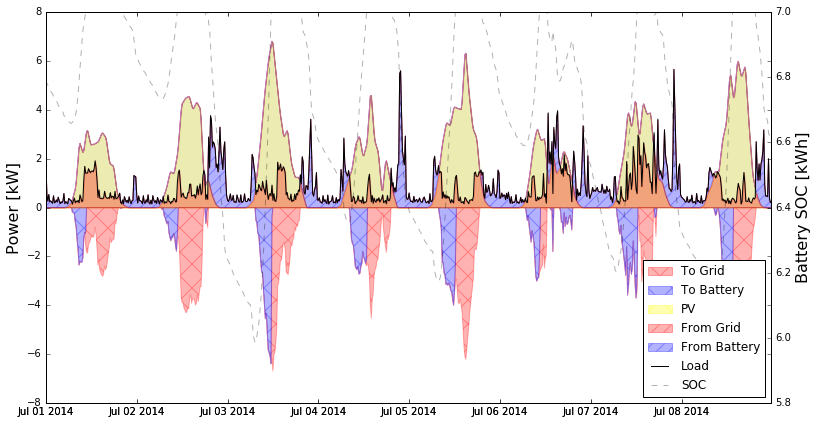

In [33]:
from SC_functions import dispatch_plot
rng = pd.DatetimeIndex(start='07/01/2014 00:00:00',end='7/8/2014 23:45:00',freq='15min')
dispatch_plot(dispatch,PV,demand,param,rng=rng)